## Style transfer

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from torchvision import models
from skimage import io, img_as_float, transform
import torchvision.transforms as transforms

from torch.autograd import Variable

import torch.optim as optim
import torchvision.models as models

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

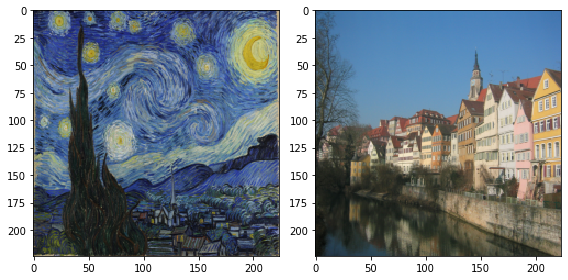

In [3]:
img_style = img_as_float(io.imread('./data/vangogh_starry_night.jpg'))
img_style = transform.resize(img_style, [224, 224])
img_content = img_as_float(io.imread('./data/Tuebingen_Neckarfront.jpg'))
img_content = transform.resize(img_content, [224, 224])

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121)
io.imshow(img_style);

ax = fig.add_subplot(122)
io.imshow(img_content);

Эмпирическим путём пришла к тому, что лучше взять не vgg16_bn, а vgg19. Соответственно, слои для подсчета потерь тоже возьму другие.

In [4]:
model = models.vgg19(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Напишем вспомогательные функции для универсальной загрузки изображений, преобразования к нужному размеру (сразу берем 224х224) и перевода в формат тензора; а также функцию для обратного преобразования.

In [5]:
def image_to_tensor(filename):
  image = Image.open(filename)
  transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor()
              ])
  image = Variable(transform(image)).view(1,-1)
  return image


def post_process_image(img):
  transform = transforms.ToPILImage()
  image = img.view(3, 224, 224)
  image = transform(image.data)
  return image


img_content = image_to_tensor('./media/Tuebingen_Neckarfront.jpg')
img_style   = image_to_tensor('./media/vangogh_starry_night.jpg')
img_input   = img_content.clone()

Проверим, что преобразования работают правильно.

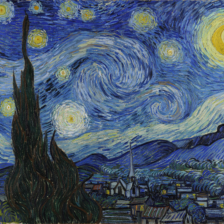

In [6]:
post_process_image(img_style)

Для удобства вынесем параметры модели в отдельный класс.

In [7]:
class StyleTransferModule(nn.Module):
  def __init__(self, args, content_image, style_image, output_image):
    super(StyleTransferModule, self).__init__()
    self.content_image = content_image
    self.style_image = style_image
    self.output_image = nn.Parameter(output_image.data)

    self.vgg19 = models.vgg19(pretrained=True).features
    self.optimizer = optim.Adam(
                       [self.output_image], 
                       lr = args.lr,
                       weight_decay = args.weight_decay
                      )
    
    self.content_loss_weight = args.content_loss_weight
    self.style_loss_weight = args.style_loss_weight

    self.content_layers = [21]
    self.style_layers = [0, 5, 10, 19, 28]

    self.loss = nn.MSELoss()

In [8]:
def gram_matrix(input):
  batch = input.size()[0]
  channels = input.size()[1]
  height = input.size()[2]
  width = input.size()[3]

  input = input.view(batch * channels, height * width)

  G = torch.mm(input, input.t())
  G = G.div(batch * channels * height * width)

  return G

In [9]:
def train(args):
  content = image_to_tensor(args.content_image)
  style = image_to_tensor(args.style_image)
  output = image_to_tensor(args.content_image)

  style_model = StyleTransferModule(args, content, style, output)
  
  for epoch in range(args.num_epochs):
    content = style_model.content_image.clone().view(1, 3, args.image_size, args.image_size)
    style = style_model.style_image.clone().view(1, 3, args.image_size, args.image_size)
    output = style_model.output_image.clone().view(1, 3, args.image_size, args.image_size)
    output.data.clamp_(0, 1)

    content_loss, style_loss, loss = 0, 0, 0

    layer_num = 0
    style_model.optimizer.zero_grad()

    for layer in style_model.vgg19:
      if type(layer) == nn.ReLU:
        layer = nn.ReLU(inplace=False)

      content = layer(content)
      style = layer(style)
      output = layer(output)

      if type(layer) == nn.Conv2d:
        if layer_num in style_model.content_layers:
          content_loss += style_model.loss(style_model.content_loss_weight * output, 
                                           style_model.content_loss_weight * content.detach())
        
        if layer_num in style_model.style_layers:
          gram_style = gram_matrix(style)
          gram_output = gram_matrix(output)
          style_loss += style_model.loss(style_model.style_loss_weight * gram_output, 
                                         style_model.style_loss_weight * gram_style.detach())
      
      layer_num += 1

    loss = content_loss + style_loss

    if epoch % 10 == 0:
      print(f'Epoch #{epoch}')
      print(f'Loss: {loss.item()}')

    loss.backward()
    style_model.optimizer.step()

  style_model.output_image.data.clamp_(0, 1)
    
  return style_model.output_image    

In [10]:
args = {
    'content_image': './media/Tuebingen_Neckarfront.jpg',
    'style_image': './media/vangogh_starry_night.jpg',
    'output_image': 'output',
    'weight_decay': 0.2,
    'lr': 0.004,
    'image_size': 224,
    'content_loss_weight': 1,
    'style_loss_weight': 4000,
    'num_epochs': 100,
}

args = pd.Series(args)

output = train(args)

Epoch #0
Loss: 25506.240234375
Epoch #10
Loss: 2835.6162109375
Epoch #20
Loss: 1292.9840087890625
Epoch #30
Loss: 869.157958984375
Epoch #40
Loss: 648.1553955078125
Epoch #50
Loss: 525.7948608398438
Epoch #60
Loss: 447.0301513671875
Epoch #70
Loss: 392.98046875
Epoch #80
Loss: 353.0553283691406
Epoch #90
Loss: 322.1749572753906


Итоговое изображение

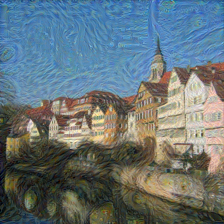

In [11]:
post_process_image(output)

Большинство параметров я подбирала эмпирически, а некоторые подсмотрела в найденных материалах.

Материалы, которые я использовала:

- Лекции с нашей платформы

- https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#introduction

- https://github.com/animesh-s/Neural-Style-Transfer